# Analysis of Food Store Accessibility in Erie County, New York
## Erin Gregoire
## Fall 2024

### Machine Learning with Decision Trees

After exploring the data presented above, one piece that stood out to me is the vast differences between the City of Buffalo and the Suburbs. Is the difference in quality food stores and income so severe between the City and the Suburbs within Erie County that we could create a model that would be able to classify which region a zipcode is located in just by its predictors? To answer this question, I built a Decision Tree model to classify the zipcodes of Erie County.
- Model: Decision Tree (Classification)
- Response Variable: Is_Buffalo where 0 = Suburbs, 1 = City of Buffalo
- Predictor Variables:
    - Income Bracket variables (Under 25k, 25k to 50k, 50k to 75k, 75k to 100k, 100k to 200k, Above 200k)
    - Total Returns
    - Store Focus variables by number (Convenience, Grocery, Multi-Purpose, Specialty, Pharmacy, Other)

In [209]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus

In [210]:
sql_statement = '''
SELECT 
    CASE WHEN loc.City = 'BUFFALO' THEN 1 ELSE 0 END AS Is_Buffalo,
    Income_Under_25k.No_of_Returns AS Returns_Under_25k,
    Income_25k_to_50k.No_of_Returns AS Returns_25k_to_50k,
    Income_50k_to_75k.No_of_Returns AS Returns_50k_to_75k,
    Income_75k_to_100k.No_of_Returns AS Returns_75k_to_100k,
    Income_100k_to_200k.No_of_Returns AS Returns_100k_to_200k,
    Income_Above_200k.No_of_Returns AS Returns_Above_200k,
    Income_Total.No_of_Returns AS Total_Returns,
    COALESCE(SUM(CASE WHEN Food_Store.Store_Focus = 'Convenience' THEN 1 ELSE 0 END), 0) AS Convenience_Stores,
    COALESCE(SUM(CASE WHEN Food_Store.Store_Focus = 'Grocery' THEN 1 ELSE 0 END), 0) AS Grocery_Stores,
    COALESCE(SUM(CASE WHEN Food_Store.Store_Focus = 'Multi-Purpose' THEN 1 ELSE 0 END), 0) AS Multi_Purpose_Stores,
    COALESCE(SUM(CASE WHEN Food_Store.Store_Focus = 'Pharmacy' THEN 1 ELSE 0 END), 0) AS Pharmacy_Stores,
    COALESCE(SUM(CASE WHEN Food_Store.Store_Focus = 'Specialty' THEN 1 ELSE 0 END), 0) AS Specialty_Stores
FROM 
    (SELECT DISTINCT Zipcode FROM Income_Under_25k
     UNION
     SELECT DISTINCT Zipcode FROM Income_25k_to_50k
     UNION
     SELECT DISTINCT Zipcode FROM Income_50k_to_75k
     UNION
     SELECT DISTINCT Zipcode FROM Income_75k_to_100k
     UNION
     SELECT DISTINCT Zipcode FROM Income_100k_to_200k
     UNION
     SELECT DISTINCT Zipcode FROM Income_Above_200k
     UNION
     SELECT DISTINCT Zipcode FROM Income_Total) AS Zipcodes
LEFT JOIN Location AS loc ON Zipcodes.Zipcode = loc.Zipcode
LEFT JOIN Income_Under_25k ON Income_Under_25k.Zipcode = loc.Zipcode
LEFT JOIN Income_25k_to_50k ON Income_25k_to_50k.Zipcode = loc.Zipcode
LEFT JOIN Income_50k_to_75k ON Income_50k_to_75k.Zipcode = loc.Zipcode
LEFT JOIN Income_75k_to_100k ON Income_75k_to_100k.Zipcode = loc.Zipcode
LEFT JOIN Income_100k_to_200k ON Income_100k_to_200k.Zipcode = loc.Zipcode
LEFT JOIN Income_Above_200k ON Income_Above_200k.Zipcode = loc.Zipcode
LEFT JOIN Income_Total ON Income_Total.Zipcode = loc.Zipcode
LEFT JOIN Food_Store ON Food_Store.Zipcode = loc.Zipcode
GROUP BY loc.Zipcode;
'''
ml_query = pd.read_sql_query(sql_statement, conn)


In [211]:
ml_query

,Is_Buffalo,Returns_Under_25k,Returns_25k_to_50k,Returns_50k_to_75k,Returns_75k_to_100k,Returns_100k_to_200k,Returns_Above_200k,Total_Returns,Convenience_Stores,Grocery_Stores,Multi_Purpose_Stores,Pharmacy_Stores,Specialty_Stores
0,0,1190,1170,830,600,890,200,4880,2,1,1,1,3
1,0,1330,1310,890,710,1110,190,5540,3,2,2,1,1
2,0,1210,1280,820,550,680,110,4650,6,2,1,2,0
3,0,340,320,260,220,360,90,1590,2,0,0,0,1
4,0,100,90,90,60,90,20,450,1,0,0,0,0
5,0,190,190,140,100,130,0,750,0,0,1,0,1
6,0,1320,920,680,520,1080,790,5310,7,1,1,2,2
7,0,1150,660,500,430,1070,900,4710,1,0,0,0,1
8,0,280,240,190,140,310,80,1240,0,0,1,0,1
9,0,210,200,170,110,140,0,830,0,1,0,0,1


#### Prepare Data for Classification

In [213]:
predictors = ['Returns_Under_25k', 'Returns_25k_to_50k', 'Returns_50k_to_75k', 'Returns_75k_to_100k', 'Returns_100k_to_200k', 'Returns_Above_200k', 'Total_Returns', 'Convenience_Stores', 'Grocery_Stores', 'Multi_Purpose_Stores', 'Pharmacy_Stores', 'Specialty_Stores']

In [214]:
X = ml_query[predictors]
Y = ml_query['Is_Buffalo']

In [215]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

#### Build a Decision Tree for Classification

In [217]:
tree = DecisionTreeClassifier()
tree_fit = tree.fit(X_train,Y_train)
y_hat_train = tree.predict(X_train)
y_hat_test = tree.predict(X_test)

In [218]:
train_accuracy = metrics.accuracy_score(Y_train, y_hat_train)
train_accuracy = round(train_accuracy, 4)*100
f'Train Accuracy: {train_accuracy}%'

'Train Accuracy: 100.0%'

In [219]:
test_accuracy = metrics.accuracy_score(Y_test, y_hat_test)
test_accuracy = round(test_accuracy, 4)*100
f'Test Accuracy: {test_accuracy}%'

'Test Accuracy: 77.78%'

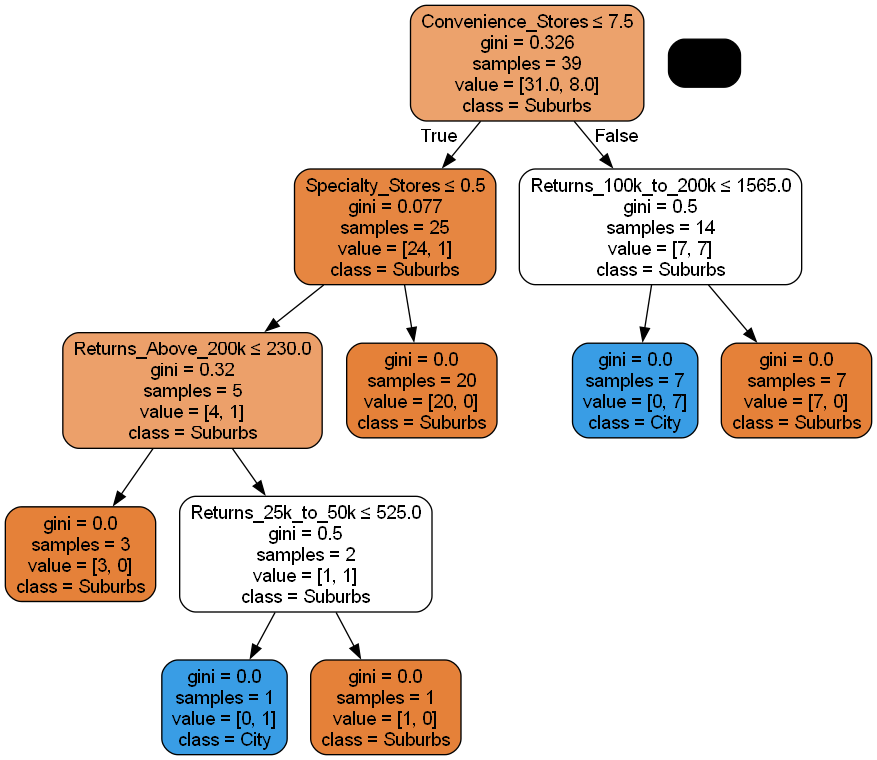

In [220]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = predictors, class_names=['Suburbs','City'])
tree_plot = pydotplus.graph_from_dot_data(dot_data.getvalue())
tree_plot.write_png('tree.png')
Image(tree_plot.create_png())

##### This first tree model does a decent job at classifying whether a record is in the City of Buffalo or in the Suburbs of Erie Country.
##### The training set received a perfect accuracy. However, this is a common problem with decision trees that without tuning parameters, the data may become overfit.
##### Let's now tune the model to see if the decision tree can become more accurate with its predictions.

In [222]:
tree2 = DecisionTreeClassifier(criterion="gini", max_depth=2)
tree_fit2 = tree2.fit(X_train,Y_train)
y_hat_train2 = tree2.predict(X_train)
y_hat_test2 = tree2.predict(X_test)

In [223]:
train_accuracy2 = metrics.accuracy_score(Y_train, y_hat_train2)
train_accuracy2 = round(train_accuracy2, 4)*100
f'Train Accuracy: {train_accuracy2}%'

'Train Accuracy: 97.44%'

In [224]:
test_accuracy2 = metrics.accuracy_score(Y_test, y_hat_test2)
test_accuracy2 = round(test_accuracy2, 4)*100
f'Test Accuracy: {test_accuracy2}%'

'Test Accuracy: 77.78%'

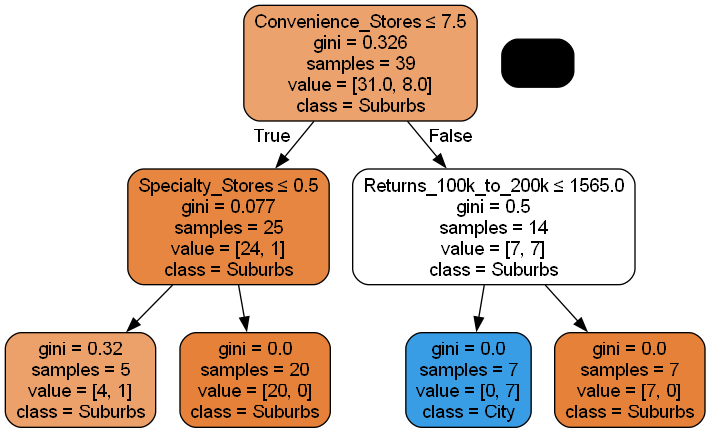

In [225]:
dot_data = StringIO()
export_graphviz(tree2, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names = predictors, class_names=['Suburbs','City'])
tree_plot2 = pydotplus.graph_from_dot_data(dot_data.getvalue())
tree_plot2.write_png('tree2.png')
Image(tree_plot2.create_png())

#### This tuned decision tree has nearly identical accuracy to the first model. However, the training accuracy shows that overfitting is less of an issue with this second model. Also, model interpretability is gained with this second model, as an extra variable is able to be pruned off while still maintaining high accuracy.
#### According to this model, the most important variables at predicting whether a record is in the City of Buffalo or in the Suburbs include the number of Convenience Stores, the number of Specialty stores, and the number of returns within the 100 to 200k income bracket.